In [1]:
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
import dill
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
events = pd.read_parquet('./sample_data/fold1/fit/smm_train_events.parquet')
user_feat = pd.read_parquet('./sample_data/fold1/fit/user_features.parquet')
user_tags = pd.read_parquet('./sample_data/fold1/fit/user_tags.parquet')

In [3]:
user_tags = user_tags.groupby('user_id')['tag_score', 'tag_level', 'user_tag'].first()

/tmp/ipykernel_17480/2117921949.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_tags = user_tags.groupby('user_id')['tag_score', 'tag_level', 'user_tag'].first()


In [4]:
user_feat = user_feat.merge(user_tags.reset_index(), on='user_id', how='left')

In [5]:
item_feat = events.groupby('item_id')['category_id'].first().reset_index()
events = events.drop(['category_id'], axis=1)

In [6]:
def make_features(df_users, user_feat):
    col_names = user_feat.columns
    cat_cols = []
    num_cols = [] 
    
    for col in col_names:
        if user_feat[col].value_counts().shape[0] <= 10:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    
    enc = LabelEncoder()
    for col in cat_cols:
        user_feat[col] = enc.fit_transform(user_feat[col])
        
    for col in tqdm(num_cols):
        user_feat[col] = pd.qcut(user_feat[col], 4, duplicates='drop').astype('category')
    
    for col in tqdm(num_cols):
        if user_feat[col].isnull().any():
            user_feat[col] = user_feat[col].cat.add_categories(col+'_unknown')
    
    for col in tqdm(num_cols):
        if user_feat[col].isnull().any():
            user_feat[col] = user_feat[col].fillna(col+'_unknown')
    for col in tqdm(num_cols):
        names = []
        n = len(user_feat[col].unique())
        for idx in range(n):
            names.append(col + '_' + str(idx))
        user_feat[col] = user_feat[col].cat.rename_categories(names)
    
    for col in tqdm(cat_cols):
        user_feat[col] = user_feat[col].astype('category')

    for col in tqdm(cat_cols):
        if user_feat[col].isnull().any():
            user_feat[col] = user_feat[col].cat.add_categories(col+'_unknown').fillna(col+'_unknown')
    
    for col in tqdm(cat_cols):
        names = []
        n = len(user_feat[col].unique())
        for idx in range(n):
            names.append(col + '_' + str(idx))
        user_feat[col] = user_feat[col].cat.rename_categories(names)
    
    user_features = np.unique(user_feat.values)
    
    return user_feat, user_features

In [7]:
user_feat_enc, user_features = make_features(user_feat, user_feat.drop(['user_id', 'user_tag', 'report_dt', 'tag_score', 'tag_level', 'f163'], axis=1))

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [8]:
user_feat = pd.concat([user_feat[['user_id', 'user_tag','tag_score', 'tag_level']], user_feat_enc], axis=1)

In [9]:
events.head()

,user_id,item_id,event,datetime
0,3386880,3108429,2,2023-02-10 21:34:17.677
1,2404320,2896309,2,2023-02-10 17:58:59.987
2,4664651,1545131,0,2023-02-10 09:40:22.000
3,3630190,401021,0,2023-02-10 12:30:29.000
4,3873537,572913,0,2023-02-10 13:12:18.000


In [10]:
max_date = events['datetime'].max()
min_date = events['datetime'].min()

min_date, max_date

(Timestamp('2023-01-15 01:20:07'), Timestamp('2023-02-12 23:58:02'))

In [11]:
train = events[(events['datetime'] < max_date - pd.Timedelta(days=7))]
test = events[(events['datetime'] >= max_date - pd.Timedelta(days=7))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (46368, 4)
test: (16847, 4)


In [12]:
lfm_date_threshold = events['datetime'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

Timestamp('2023-02-02 02:25:07.411000')

In [13]:
lfm_train = events[(events['datetime'] < lfm_date_threshold)]
lfm_pred = events[(events['datetime'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (37928, 4)
lfm_pred: (25287, 4)


In [14]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]

In [15]:
from lightfm.data import Dataset
from lightfm import LightFM

In [16]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())
dataset.fit_partial(user_features=user_features)

In [17]:
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'event']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [18]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 1165
items_mapping amount: 11242


In [19]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42
)

In [20]:
num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
with open(f"lfm_model.dill", 'wb') as f:
    dill.dump(lfm_model, f)

In [22]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper


def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)


In [23]:
candidates = pd.DataFrame({
    'user_id': lfm_pred['user_id'].unique()
})

candidates.head(3)

,user_id
0,2404320
1,4664651
2,3630190


In [24]:
top_N = 100

all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [25]:
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1 

candidates.head()

,user_id,item_id,rank
0,2404320,452365,1
0,2404320,1290849,2
0,2404320,2344401,3
0,2404320,2804677,4
0,2404320,649181,5


In [26]:
candidates.shape

(52500, 3)

In [27]:
pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(3098, 6)


,user_id,item_id,rank,event,datetime,target
0,3630190,3248170,85,0,2023-02-10 12:30:29.000,1
1,3630190,3248170,85,0,2023-02-10 12:30:29.000,1
2,3630190,3248170,85,0,2023-02-11 07:40:49.000,1
3,3630190,3248170,85,0,2023-02-11 07:40:49.000,1
4,5755584,459886,1,2,2023-02-02 09:11:57.376,1


In [28]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))

neg = neg[neg['event'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(3627, 6)

In [29]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [30]:
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.2)

In [31]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

In [32]:
ctb_train['target'].value_counts(normalize=True)

0    0.54408
1    0.45592
Name: target, dtype: float64

In [33]:
ctb_test['target'].value_counts(normalize=True)

0    0.558069
1    0.441931
Name: target, dtype: float64

In [34]:
train_feat = ctb_train.merge(user_feat[['user_id','f1', 'f40', 'f156', 'f101', 'tag_score', 'tag_level']],
                           on=['user_id'],
                           how='left')\
                        .merge(item_feat[['item_id', 'category_id']],
                              on=['item_id'],
                              how='left')

eval_feat = ctb_eval.merge(user_feat[['user_id','f1', 'f40', 'f156', 'f101', 'tag_score', 'tag_level']],
                           on=['user_id'],
                           how='left')\
                    .merge(item_feat[['item_id', 'category_id']],
                              on=['item_id'],
                              how='left')

In [35]:
drop_col = ['user_id', 'item_id']
target_col = ['target']

In [36]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [37]:
from catboost import CatBoostClassifier

ctb_model = CatBoostClassifier(iterations=5000)

In [38]:
X_train.head()

,rank,f1,f40,f156,f101,tag_score,tag_level,category_id
0,48,f1_1,f40_0,f156_3,f101_3,1.00,1.0,1196
1,67,f1_3,f40_2,f156_3,f101_3,0.75,3.0,7471
2,94,f1_0,f40_4,f156_0,f101_3,1.00,1.0,786
3,14,f1_0,f40_1,f156_1,f101_0,0.72,2.0,2110
4,31,f1_0,f40_3,f156_0,f101_3,0.69,3.0,8504


In [39]:
ctb_cat = list(X_train.drop(['rank'], axis=1).columns)

In [40]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_train.mode().iloc[0])

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4299 entries, 0 to 4298
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   rank         4299 non-null   int64   
 1   f1           4299 non-null   category
 2   f40          4299 non-null   category
 3   f156         4299 non-null   category
 4   f101         4299 non-null   category
 5   tag_score    4299 non-null   float32 
 6   tag_level    4299 non-null   float64 
 7   category_id  4299 non-null   int32   
dtypes: category(4), float32(1), float64(1), int32(1), int64(1)
memory usage: 151.9 KB


In [42]:
ctb_cat

['f1', 'f40', 'f156', 'f101', 'tag_score', 'tag_level', 'category_id']

In [43]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              cat_features=['f1', 'f40', 'f156', 'f101'],
              early_stopping_rounds=100,
              verbose=10)

Learning rate set to 0.022558
0:	learn: 0.6819886	test: 0.6891157	best: 0.6891157 (0)	total: 49.9ms	remaining: 4m 9s
10:	learn: 0.5828610	test: 0.6518887	best: 0.6518887 (10)	total: 69.3ms	remaining: 31.4s
20:	learn: 0.5167310	test: 0.6369947	best: 0.6369947 (20)	total: 87.6ms	remaining: 20.8s
30:	learn: 0.4733104	test: 0.6325897	best: 0.6325897 (30)	total: 107ms	remaining: 17.1s
40:	learn: 0.4398635	test: 0.6416048	best: 0.6315898 (32)	total: 125ms	remaining: 15.2s
50:	learn: 0.4114143	test: 0.6498413	best: 0.6315898 (32)	total: 144ms	remaining: 13.9s
60:	learn: 0.3890005	test: 0.6680625	best: 0.6315898 (32)	total: 163ms	remaining: 13.2s
70:	learn: 0.3702798	test: 0.6959019	best: 0.6315898 (32)	total: 183ms	remaining: 12.7s
80:	learn: 0.3550723	test: 0.7180693	best: 0.6315898 (32)	total: 210ms	remaining: 12.7s
90:	learn: 0.3427445	test: 0.7396084	best: 0.6315898 (32)	total: 230ms	remaining: 12.4s
100:	learn: 0.3319889	test: 0.7546272	best: 0.6315898 (32)	total: 248ms	remaining: 12s
11

In [44]:
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

In [45]:
test_feat = ctb_test.merge(user_feat[['user_id','f1', 'f40', 'f156', 'f101', 'tag_score', 'tag_level']],
                           on=['user_id'],
                           how='left')\
                    .merge(item_feat[['item_id', 'category_id']],
                              on=['item_id'],
                              how='left')

In [46]:
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [47]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [48]:
X_test.head()

,rank,f1,f40,f156,f101,tag_score,tag_level,category_id
0,100,f1_1,f40_1,f156_1,f101_2,0.96,5.0,5429
1,54,f1_3,f40_0,f156_1,f101_3,1.00,1.0,981
2,52,f1_1,f40_0,f156_3,f101_3,0.66,3.0,5584
3,32,f1_3,f40_0,f156_1,f101_0,1.00,1.0,8591
4,15,f1_3,f40_3,f156_3,f101_3,1.00,1.0,4480


In [49]:
y_pred = ctb_model.predict_proba(X_test)

In [50]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.70'

In [51]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]

In [52]:
# кол-во кандидатов берем больше, чем для обучения
# чтобы катбусту было, что ранжировать
top_N = 200

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

known_items = lfm_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

In [53]:
lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction, 
                              top_N=10)
lfm_metrics

Precision@1     0.168950
Recall@1        0.008316
Precision@2     0.116438
Recall@2        0.013083
Precision@3     0.109589
Recall@3        0.018867
Precision@4     0.108447
Recall@4        0.023080
Precision@5     0.094064
Recall@5        0.026590
Precision@6     0.086758
Recall@6        0.028918
Precision@7     0.100457
Recall@7        0.030705
Precision@8     0.096176
Recall@8        0.031444
Precision@9     0.091578
Recall@9        0.033152
Precision@10    0.087671
Recall@10       0.035995
MAP@10          0.067661
MRR             0.085257
dtype: float64

In [54]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(user_feat[['user_id', 'f1', 'f40', 'f156', 'f101','tag_score', 'tag_level']] ,
                                   on=['user_id'],
                                   how='left')\
                                .merge(item_feat[['item_id', 'category_id']],
                                  on=['item_id'],
                                  how='left')
# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [55]:
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,ctb_pred
0,2404320,452365,1,0.575258
1,2404320,1290849,2,0.575258
2,2404320,2344401,3,0.575258


In [56]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=['f1', 'f40', 'f156', 'f101']), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

In [57]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
16199,1013292,1477353,200
16126,1013292,1000682,127
16127,1013292,555570,128
16128,1013292,1223027,129
16129,1013292,1985328,130
16130,1013292,2949071,131
16131,1013292,3352565,132
16132,1013292,617503,133
16133,1013292,2720758,134
16134,1013292,2618894,135


In [58]:
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [59]:
lfm_ctb_prediction.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
16008,1013292,1610804,9,0.483889,1
16007,1013292,3303625,8,0.483330,2
16004,1013292,1734930,5,0.474236,3
16002,1013292,695008,3,0.473679,4
16003,1013292,757894,4,0.473679,5
16005,1013292,1580881,6,0.473679,6
16006,1013292,50578,7,0.473679,7
16000,1013292,3014073,1,0.466267,8
16001,1013292,2359194,2,0.466267,9
16010,1013292,1468950,11,0.463285,10


In [60]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.326484
Recall@1        0.004448
Precision@2     0.271689
Recall@2        0.013901
Precision@3     0.290715
Recall@3        0.017841
Precision@4     0.242009
Recall@4        0.021465
Precision@5     0.218265
Recall@5        0.027297
Precision@6     0.208524
Recall@6        0.029491
Precision@7     0.183953
Recall@7        0.032130
Precision@8     0.174372
Recall@8        0.036021
Precision@9     0.160578
Recall@9        0.038541
Precision@10    0.149087
Recall@10       0.039340
MAP@10          0.117893
MRR             0.087954
dtype: float64

In [61]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.168950,0.008316,0.116438,0.013083,0.109589,0.018867,0.108447,0.023080,0.094064,0.026590,...,0.100457,0.030705,0.096176,0.031444,0.091578,0.033152,0.087671,0.035995,0.067661,0.085257
model_2step,0.326484,0.004448,0.271689,0.013901,0.290715,0.017841,0.242009,0.021465,0.218265,0.027297,...,0.183953,0.032130,0.174372,0.036021,0.160578,0.038541,0.149087,0.039340,0.117893,0.087954


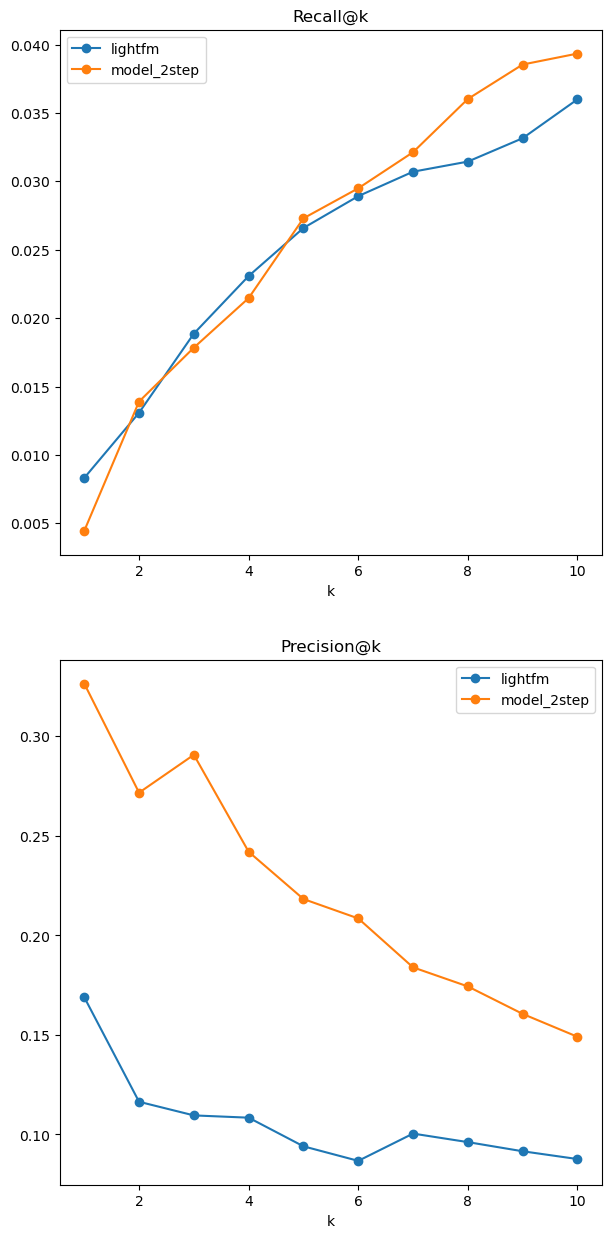

In [62]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')